In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy
import scipy
import random
import matplotlib as mpl
import pylab as plt
import time
import numba
import itertools
import math
#
import multiprocessing as mpp
import multiprocess as mp
#
import calc_pi as cp
import calc_mandelbrot as cmb
#

# Python: (some) best practices, optimizations, and parallelization

# Calculate Pi

(Content borrowed shamelessly from SW Carpentry, [https://www.hpc-carpentry.org/hpc-parallel-novice/04-mapreduce-of-files/index.html].

Here, we demonstrate an area based, Reno-Nevada (poor person's Monte Carlo) method to estimate $pi$. We draw random numbers over a square with sides $L = 2R = 2$ and count the fraction of points that fall inside an enclosed circle with radius $R$. Eventually we will add a figure.

The gist of the formula is,

$\frac{N_{captured}}{N_{total}} = \frac {\pi R^2}{(2R)^2}$


Use this little PI calculator to illustrate methods of optimnization and parallelization. These will include:

1. Loop-loop (nested loop), which is a trainwreck for Python...
2. @numba.jit the loop-loop
3. Vectorize the random numbers
4. Parallelize various ways.
  1. Process() ?
  2. multiprocessing.Pool().map() ( and variants)
  3. mpi4py ?
  4. Embarrasingly parallel approach?



### First draft implementation
- Start with the simplest implementation
- NOTE: this is generally speaking a pretty terrible way to use Python
- But it illustrates all the main things.
- We will discuss how to improve it later.

In [3]:

# The base function:
def calc_pi_nogil(N):
    M = 0
    for i in range(int(N)):
        x = random.uniform(-1, 1)
        y = random.uniform(-1, 1)
        if x**2 + y**2 < 1:
            M += 1
    return 4 * M / N

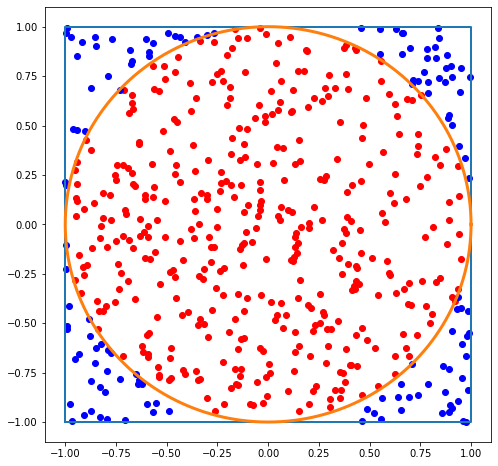

In [4]:
def draw_circle(R=1, N=1000):
    thetas = numpy.linspace(0., 2.*math.pi, N+1)
    #return numpy.array([(x,y) for x,y in zip(numpy.cos(thetas), numpy.sin(thetas))],
    #                  dtype=[('x','<f8'), ('y', '<f8')])
    return numpy.array([numpy.cos(thetas), numpy.sin(thetas)]).T
#
fg = plt.figure(figsize=(8,8))
ax = fg.add_subplot(1,1,1)
#
R = 1.
circ = draw_circle(R=R)
samples = numpy.random.random((550,2))*2.*R - R
ix = numpy.sum(samples*samples, axis=1) < (R*R)

ax.plot(R*numpy.array([-1., 1., 1., -1., -1.]), R*numpy.array([-1., -1., 1., 1., -1.]), lw=2)
ax.plot(*circ.T, lw=3)
ax.scatter(*(samples[ix]).T, marker='o', color='r')
ax.scatter(*(samples[numpy.invert(ix)]).T, marker='o', color='b')


### Benchmark this function for $N$

In [5]:
# This is the simplest, most straight forward calculation.
#
t1 = time.time()
PIs = []
for N_max in numpy.arange(1E3, 1E5, 1E4):
    #print(f'*** Computing Pi for {N_max}')
    t0=time.time()
    PIs += [[N_max, calc_pi_nogil(int(N_max)), time.time()-t0]]
dt_ll = time.time()-t1
print(f'** dt: {dt_ll}')
#
print('** Pi vals: ')
for n,pi,t in PIs:
    print(f'{n} :: {pi} :: {t}')
#


** dt: 0.3970479965209961
** Pi vals: 
1000.0 :: 2.992 :: 0.001631021499633789
11000.0 :: 3.1483636363636363 :: 0.010374069213867188
21000.0 :: 3.1312380952380954 :: 0.016688823699951172
31000.0 :: 3.1550967741935483 :: 0.028280019760131836
41000.0 :: 3.1493658536585367 :: 0.03621673583984375
51000.0 :: 3.136549019607843 :: 0.040329933166503906
61000.0 :: 3.134622950819672 :: 0.05369997024536133
71000.0 :: 3.132338028169014 :: 0.06091713905334473
81000.0 :: 3.134716049382716 :: 0.06865191459655762
91000.0 :: 3.1398241758241756 :: 0.07979106903076172


## Some optimizations


## List comprehensions

A list comprehension is a more compact, some will say more intuitive and readable (others will disagree with one or more of those characteriztions) way to construct a list in Python. List comprehensions are usually faster than aggregating,  or even creating a list to size and assiging values (ie, PIs=list(NN_max) vs PIs=[]), albeit not always significantly.

But note that it can be difficult or not possible to do more complex, multi-step actions in a list comprehension.

In [6]:
# List comprehension way (a little bit faster...)
# this:
# X = []
# for k in range(n):
#     X+=[f(k)]
# becomes:
# X = [f(k) for k in range(n)]
#
t1 = time.time()
PIs = [[N_max, calc_pi_nogil(int(N_max))] for N_max in numpy.arange(1E3, 1E5, 1E4)]
print(f'** dt: {time.time()-t1}')
#
print('** Pi vals: ')
for n,pi in PIs:
    print(f'{n} :: {pi}')
#


** dt: 0.38182806968688965
** Pi vals: 
1000.0 :: 3.184
11000.0 :: 3.1374545454545455
21000.0 :: 3.1419047619047618
31000.0 :: 3.1472258064516128
41000.0 :: 3.1485853658536587
51000.0 :: 3.148941176470588
61000.0 :: 3.146032786885246
71000.0 :: 3.1375211267605634
81000.0 :: 3.1516543209876544
91000.0 :: 3.145010989010989


## Vectorization
- Probably first, most reliable and stable optimization
- Pass a sequence (vector) of values to the processor, rather than one variable at a time
- Makes _MUCH_ better use of the processers cache(s)
- Often simplified syntax _AND_ much improved performance.

Let's rewrite calc_pi(), a little more creatively.


In [7]:
def calc_pi_vec(N):
    #M = 0
    # spell it out, then consolidate...
    #X = 2. * numpy.random.random(N) - 1.
    #Y = 2. * numpy.random.random(N) - 1.
    #Z = X**2 + Y**2
    #
    # All of that in one line...
    # You should experiment with some of this syntax to evaluate performance.
    # this looks much faster than numpy.square()
#    Z = numpy.sum( numpy.random.uniform(-1., 1., (2,N) )**2. , axis=0 )
#    #Z = numpy.sum( numpy.square( numpy.random.uniform(-1.,1., (2,N) ) ), axis=0 )
#    #
#    # as a little trick, sum the index of (Z<1)
#    M = numpy.sum((Z<1))
    
    #M = numpy.sum( (numpy.sum( numpy.random.random( (2,N) )**2. , axis=0 ))<1 )
    M = numpy.sum( (numpy.sum( numpy.random.uniform(-1,1, (2,N) )**2. , axis=0 ))<1 )
    #
    return 4.0*M/N


## numba
- Use `@jit` to pre-compile the function.
- This often works _REALLY_ well for simple, just-math functions. Numpy containers, internal functions, etc. have potential to confuse `numba`
- So numba is often a way to make a really bad code (eg, a loop-loop), really good, but it can be complicated to make a pretty-good code much better.
- `numba` also has some compile-time options, which we will show below. These include:
  - Releasing the `GIL`
  - (almost!) Automagical parallelization (much like `parfor`)
- `numba` can be annoying to work with. There are cases where it will generate loads of warning messages, which are difficult to suppress.
- You have to be realy careful to keep your parallel codes thread-safe


In [8]:
## Compile with Numba:
#
@numba.jit()
def calc_pi_1(N):
    M = 0
    for i in range(int(N)):
        x = random.uniform(-1, 1)
        y = random.uniform(-1, 1)
        if x**2 + y**2 < 1:
            M += 1
    return 4 * M / N

@numba.jit(nopython=True)
def calc_pi_2(N):
    M = 0
    for i in range(int(N)):
        x = random.uniform(-1, 1)
        y = random.uniform(-1, 1)
        if x**2 + y**2 < 1:
            M += 1
    return 4 * M / N

@numba.jit(nopython=True, nogil=True)
def calc_pi_3(N):
    M = 0
    for i in range(int(N)):
        x = random.uniform(-1, 1)
        y = random.uniform(-1, 1)
        if x**2 + y**2 < 1:
            M += 1
    return 4 * M / N
#
# How 'bout this?
@numba.njit(parallel=True)
def calc_pi_njp(N):
    M = 0
    for i in numba.prange(int(N)):
        x = random.uniform(-1, 1)
        y = random.uniform(-1, 1)
        if x**2 + y**2 < 1:
            M += 1
    return 4 * M / N

## Benchmark
- Compare performance for loop-loop, vectorization, and versions of `numba.jit`
- Note that `numba.jit` performs much better for this example. 
- There are likely some subtlties in the vectorization that can be resolved, but...
- Mostly, this is because our kernel functions are just pure Python math, which are put through a simple loop If there were other libries included in those functions, eg. `random.random()` let alone anything `numpy`, `numba` would likely throw a bunch of warnings and the acceleration would be reduced.

### Comments on benchmarking:
- Straight forward(ish), but can be tricky! Some things to look out for...
- SW or HW solutions that "help" by cacheing results (maybe chanbe up the problem a little bit?)
- For `numba` (and other optimizers), run a small job first, to be sure the code compiles
- Is there some other overhead affecting your benchmark?
- `%timeit` is pretty awesome, but beware artifacts from overhead...
- Is your computer doing other things too?
- Understand the problem and the code and stategize accordingly. Eg, is `range(10E7)` equivalent (better?) than `[f(10E7) for k in range(10)]`


In [9]:
# try the different jit-compile options:
#
N_max=1E7
for f in (cp.calc_pi_loop_loop, cp.calc_pi_vec, cp.calc_pi_jit,\
          cp.calc_pi_jit_np, cp.calc_pi_jit_ng, cp.calc_pi_jit_ng_np,\
         calc_pi_njp):
    # 
    # do a quick run, so we dont' count compile time.
    dummy_var = f(500)
    t1 = time.time()
    #PIs = [[N_max, f(int(N_max))] for N_max in numpy.arange(1E3, 1E5, 1E4)]
    pi = f(int(N_max + random.randint(1,10)))
    print(f'f = {f.__name__}')
    print(f'** dt: {time.time()-t1}')
    print(f'** pi: {pi}\n')
    #
#     print('** Pi vals: ')
#     for n,pi in PIs:
#         print(f'{n} :: {pi}')

f = calc_pi_loop_loop
** dt: 6.982046842575073
** pi: 3.1413373151976107

f = calc_pi_vec
** dt: 0.3411750793457031
** pi: 3.1410549153670506

f = calc_pi_jit
** dt: 0.11314582824707031
** pi: 3.14229820039126

f = calc_pi_jit_np
** dt: 0.1015021800994873
** pi: 3.1409593718081257

f = calc_pi_jit_ng
** dt: 0.10725593566894531
** pi: 3.141265658734341

f = calc_pi_jit_ng_np
** dt: 0.10219097137451172
** pi: 3.1412148587851414

f = calc_pi_njp
** dt: 0.026676177978515625
** pi: 3.1418237716352455



## `numba` parallel
- Note the `numba.njit(parallel=True)` compilation/decoration example above.
- For simple loops, this may be about as good as it gets
- But as discussed, its applicaiton may be limited, and you have to be careful.


## Embarrasingly parallel
- Kind of a dumb example, unless we make the problem much bigger. Maybe Mandelbrot?
- Alas... The idea is to run many independent instances, then separately collect and aggregate.
- Consider a wrapper functoin:
```
    def calc_pi_n_write(f_pi=calc_pi_jit_np, Nits=int(1E7), fout_name=None):
    '''
    # comput pi and output to fout. We will use this as a simple demonstrator of emb. parallal.
    '''
    pi = f_pi(Nits)
    #
    if not fout_name is None:
        with open(fout_name, 'a') as fout:
            fout.write(f'pi:{pi}\n')
    return pi
```
- Which we can submit to the scheduler with something like this:
```
    #!/bin/bash
    #
    #SBATCH --job-name=e-p_compute_pi
    #SBATCH --output=comp_pi.out
    #SBATCH --error=comp_pi.err
    #SBATCH --mem-per-cpu=1g
    #SBATCH --cpus-per-task=1
    #SBATCH --ntasks=1
    #SBATCH --partition=serc,normal,owners
    #SBATCH --time=00:10:00
    #
    module purge
    #module load python/3.9
    #module load py-sherlock/
    module load anaconda/3.11
    #
    PI_OUTPUT=ep_pi.csv
    #
    python3 -c "import calc_pi as cp;cp.calc_pi_n_write(fout_name='${PI_OUTPUT}')"
```
- We can submit/run multiple instances by either:
  - Submitting a whole bunch of individual jobs: This is sloppy, hard on the scheduler, and will make Kilian angry.
  - Job array (eg, `--array=0-100%10`): This is usually optimal. We can submit LOTS of instances, but still control concurrent resource use with the `%` operator.
    - `sbatch --array=0-16 e_paralell_pi.sh `
  - `--ntasks`: This is not really what `--ntasks` was meant to do, but it will work. In this case, it will launch `--ntasks` instances, simultaneously and running in parallel.
    - `sbatch --ntasks=16 e_paralell_pi.sh `
 
 

## Parallel compute: Multiprocessing
Parallel computation in Python is fundamentally limited by the Global Interpreter Lock (GIL), which basically limits Python to do one thing at a time. You can, for example, launch tasks as threads -- which in other envoronments might be allowed to run in parallel, but in Python, those threads run sequentially.

There are two basic approaches to working around the GIL:
1. Use (compiled) components that operate in parallel -- but appear effectively serial to Python
2. Launch multiple instances of Python

There are numerous examples of the first case. We have already seen that `numba` can do this. we also see this in many compilations of `numpy` matrix algebra. The built in Python module `multiprocessing` takes the second approach. Though it is limited to a single machine, `multiprocessing` in some ways resembles an MPI framework -- a comput job is broken up into pieces, then "pickled" (serialized) and run as independent processes; the GIL is maintained in each separeat thread.

The main disadvantages of `multiprocessing` is that there is relatively high compute and memory overhead -- since the entire process has to be copied, and it can be programmatically complicated (nominally, simpler than most MPI programs, but more difficult than `parfor`). Another disadvantage is that -- as mentioned, it is limited to a single machine.

On that latter note, consider the cousin library, `multiprocess` -- more or less a copy of `multiprocessing` that includes several multi-node options -- eg, an MPI capagle `Pool()` class. Note that multiprocessing, and especially MPI, or other multi-node capable options, appear to be a very active work in progress at this time (Oct 2023), so there might be other good options available (see for example `pip install mpipool`... I think).

For now we focus on `multiprocessing`. Some of the salient components include:

- Process(): The simplest example, nominally applies well to this example
- Pool(): Sort of a dumb way to use a Pool(), but we're in the business of making examples
- Queue(): I've never used a queueu, but...

**NOTE:** Multiprocessing will _not_ work in notebooks. Parallelized functions must be off-loaded to a .py module, so that the function can be properly referenced and copied when it is serialized.


## MPP structural elements
- Pipe()
- Process()
- Pool()
- Other things too...
- (NOTE: these codes are reproduced in an external module so they can be run in parallel).

In [10]:
# MPP Process()
#. it is possible that the syntax for this has changed, which is to say that this attempt and even the 
#. line-for-line example from the docs does not appear to run. 
# Note that these codes will not run in parallel, but their off-notebook counterparts will.
#
# Sometimes, there are lots of wrapper functions in parallel Python programming.

# try this:
def calc_pi_pipe(N, conn):
    '''
    # A simple demonstration of how to use Pipe() comm pairs. Basically replace or agment return x
    # with conn.send(x)
    '''
    M = 0
    for i in range(int(N)):
        x = random.uniform(-1, 1)
        y = random.uniform(-1, 1)
        if x**2 + y**2 < 1:
            M += 1
    #return 4 * M / N
    conn.send([N, 4*M/N])
    conn.close()

def pipe_wrapper(f, n_max, conn):
    '''
    # If you have a workiong function f , you might run it with a process (or do something else)
    # by wrapping it in a function like this. Note that this looks super generalized, but it actually
    # has a very specific call signature.
    # more versatile wrappers use the *args, **kwargs inputs, but this can create its own issues, so...
    '''
    pi = f(n_max)
    #print('*** ', pi)
    conn.send([n_max, pi])
    conn.close()
    #
    #return None
    

#def f_process(f=None, n_processes=1, N_max=1000, *args):
def f_process(f=None, n_processes=1, N_max=1000):
    '''
    # A quick-n-dirty way to wrap a function f so we can run it as a Process()
    '''
    # This is a sort of stupid way to write this function, but it gets the job done.
    # production applications will probably be either much better generalized or much more specific.
    #
    #args = [f, N_max] + list(args)
    #
    pipes = [mpp.Pipe() for k in range(n_processes)]
    Ps = [mpp.Process(target=pipe_wrapper, args=tuple([f, N_max, p2])) for p1,p2 in pipes]
    #Ps = [mpp.Process(target=calc_pi_pipe, args=tuple([N_max, p2])) for p1,p2 in pipes]
    #
    for (p1, p2), p in zip(pipes, Ps):
        print("*** Starting process...", p, p1, p2)
        # NOTE: this will not do anything if f (or the rest of this???) is in a notebook.
        #p.start()
        #p.join()
        # this will work in a notebook, but will run serially.
        p.run()
        #p1.recv()
        

        
#    for p in Ps:
#        p.join()
#     print('*** jobs started, now recv()')
#     for p in Ps:
#         p.close()
#     pis = [p1.recv() for p1, p2 in pipes]
    #
    pis = [p1.recv() for p1, p2 in pipes]
    #
    # Ugh...
    # TODO: 
    #. to get results from this, each process either needs to point somewhere for an output,
    #. you can pass a queue a parameter to collect output, our you have to set up Pipe() objects.
    #Results = [p.get() for p in Ps]
    #
    #return Results
    
    return pis
    
    

### Examples of using Process(), Pipe(), etc.
- These do not actually parallelize...
- But we illustrate how to use some of these classes and functions.


In [11]:
#pi = f_process(calc_pi_nogil, 4, N_max=10000)
pi = f_process(calc_pi_vec, 4, N_max=10000)
#

p1, p2 = mpp.Pipe()
print('** ', pipe_wrapper(cp.calc_pi_vec, int(1E7), p2))
print('** **: ', p1.recv())

p1,p2 = mpp.Pipe()
print('** ', calc_pi_pipe(int(1E7), p2))
#print('** ', pipe_wrapper(calc_pi_vec, 500, p2))
print('** **: ', p1.recv())


*** Starting process... <Process name='Process-1' parent=33110 initial> <multiprocessing.connection.Connection object at 0x7f98ab158eb0> <multiprocessing.connection.Connection object at 0x7f98ab158e20>
*** Starting process... <Process name='Process-2' parent=33110 initial> <multiprocessing.connection.Connection object at 0x7f98ab158d90> <multiprocessing.connection.Connection object at 0x7f98c2f57b50>
*** Starting process... <Process name='Process-3' parent=33110 initial> <multiprocessing.connection.Connection object at 0x7f98c2f577c0> <multiprocessing.connection.Connection object at 0x7f98c2f57dc0>
*** Starting process... <Process name='Process-4' parent=33110 initial> <multiprocessing.connection.Connection object at 0x7f98ab26cac0> <multiprocessing.connection.Connection object at 0x7f98ab3c31f0>
**  None
** **:  [10000000, 3.1412324]
**  None
** **:  [10000000, 3.1409392]


### Example: Use a generalized wrapper function to run one of several pi calculations in a Process()
- Note the use of: *args, **kwargs

In [12]:
# Another example of a simple wrapper script:
# run function f() in a Process(); pass *args and **kwargs; return output via a Pipe()
#
N_max = int(1E7)
def f_pipe(f, pipe, *args, **kwargs):
    x = f(*args, **kwargs)
    pipe.send(x)
    pipe.close()

for f in cp.calc_pi_loop_loop, cp.calc_pi_vec, calc_pi_njp, cp.calc_pi_njp:
    # create a comm/Pipe() pair:
    p1, p2 = mpp.Pipe()
    t1 = time.time()
    #P = mpp.Process(target=f_pipe, args=[cp.calc_pi_loop_loop, p2, int(N_max)])
    P = mpp.Process(target=f_pipe, args=[f, p2, int(N_max + random.randint(1,100))])
    #
    # NOTE: in our notebook, we use P.run(), which is serial. For parallel function,
    #  we need to move the code to a .py module and use P.start()
    P.run()
    pi = p1.recv()

    P.close()
    p1.close()
    p2.close()
    #
    print(f'** f = {f}')
    print(f'*** pi={pi}, dt={time.time()-t1}\n' )
#

** f = <function calc_pi_loop_loop at 0x7f98c2bf44c0>
*** pi=3.14071927125281, dt=6.952842950820923

** f = <function calc_pi_vec at 0x7f98c2bf4550>
*** pi=3.1417178866256905, dt=0.3155639171600342

** f = CPUDispatcher(<function calc_pi_njp at 0x7f98c2f8fee0>)
*** pi=3.141944548971522, dt=0.028728723526000977

** f = CPUDispatcher(<function calc_pi_njp at 0x7f98c2bf4f70>)
*** pi=3.1407180919175333, dt=0.32920026779174805



### Use pool_wrapper() to run some of our calculators in parallel.

In [13]:
N=int(1E7)
print('*** ', cp.calc_pi_jit(N))
print('*** 4cpus', cp.pool_wrapper(f=cp.calc_pi_jit, ncpus=4, f_agg=numpy.mean, N=N))
print('*** 1cpu', cp.pool_wrapper(f=cp.calc_pi_jit, ncpus=1, N=N))
#
# now, try the recursive wrapper:
print('** using calc_pi() with the recursive bit')
for n in range(1,5):
    print(f'*** [{n}]: {cp.calc_pi(N, n)}')



***  3.1422376
*** 4cpus [3.1419102]
*** 1cpu 3.1409504
** using calc_pi() with the recursive bit
*** [1]: 3.1425036
*** [2]: 3.1419216
*** [3]: 3.1405839140583915
*** [4]: 3.1415771999999995


In [14]:
# Now, try with the nested recursive bit:
t1 = time.time()
pi_v = cp.calc_pi_vec(N_max*10)
print(f'vector ({pi_v}):: {time.time()-t1}')

t1 = time.time()
pi_vr = cp.calc_pi_vec_mpp(N_max*10, ncpus=4)
print(f'vector_mpp ({pi_vr}):: {time.time()-t1}')
#

vector (3.1416936):: 3.8643479347229004
vector_mpp (3.1414784):: 2.5324859619140625


In [15]:
# try the jit recursive bit and introduce timeit:
for n in range(1,5):
    #%timeit print(f'mpp[{n}]: {cp.calc_pi(1E6, n)}')
    %timeit print(f'pool[{n}]: {cp.calc_pi_pool(ncpu=n, N_max=int(1E6/n))}')
#

pool[1]: 3.140808
pool[1]: 3.141704
pool[1]: 3.144256
pool[1]: 3.142248
pool[1]: 3.143224
pool[1]: 3.141916
pool[1]: 3.14248
pool[1]: 3.144156
1.85 s ± 57.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
pool[2]: 3.1416880000000003
pool[2]: 3.140156
pool[2]: 3.142344
pool[2]: 3.140508
pool[2]: 3.141952
pool[2]: 3.145156
pool[2]: 3.140136
pool[2]: 3.144936
2.07 s ± 407 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
pool[3]: 3.141783141783142
pool[3]: 3.1443911443911445
pool[3]: 3.14003514003514
pool[3]: 3.142831142831143
pool[3]: 3.14051514051514
pool[3]: 3.143119143119143
pool[3]: 3.1415311415311415
pool[3]: 3.1424671424671424
2.01 s ± 274 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
pool[4]: 3.1415119999999996
pool[4]: 3.1443320000000003
pool[4]: 3.14396
pool[4]: 3.1410280000000004
pool[4]: 3.1427760000000005
pool[4]: 3.140528
pool[4]: 3.1415360000000003
pool[4]: 3.1407239999999996
2.02 s ± 129 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [16]:
# try the jit recursive bit and introduce timeit:
print(f'*** mpp.cpu_count(): {mpp.cpu_count()}')
NN = int(1E7)
for n in range(1,7):
    t0 = time.time()
    print(f'mpp[{n}]: {cp.calc_pi(NN, n)}')
    print(f'** time[{n}]: {time.time()-t0}')
    #
    t0 = time.time()
    print(f'pool[{n}]: {cp.calc_pi_pool(ncpu=n, N_max=int(NN/n))}')
    print(f'** time[{n}]: {time.time()-t0}')
    print('\n')
#

*** mpp.cpu_count(): 8
mpp[1]: 3.1420508
** time[1]: 7.322984933853149
pool[1]: 3.1412928
** time[1]: 8.548772811889648


mpp[2]: 3.1418055999999996
** time[2]: 3.015634775161743
pool[2]: 3.1413972
** time[2]: 4.679225921630859


mpp[3]: 3.1417187141718714
** time[3]: 4.007036209106445
pool[3]: 3.1422803142280316
** time[3]: 3.887021064758301


mpp[4]: 3.1411992
** time[4]: 6.573313236236572
pool[4]: 3.141018
** time[4]: 4.657909393310547


mpp[5]: 3.1418612
** time[5]: 7.051474332809448
pool[5]: 3.1417612
** time[5]: 4.255016803741455


mpp[6]: 3.141517656607063
** time[6]: 8.807291984558105
pool[6]: 3.1423660569464222
** time[6]: 5.2647058963775635




In [17]:
N_max = int(1E7)
f_pi = cp.calc_pi_loop_loop
#f_pi = cp.calc_pi_vec
t1 = time.time()
pi=f_pi(N_max)
print(f'*** pi={pi}, dt={time.time()-t1}' )
#
print('*** Single process, off-loaded:')
# Now, do a single off-loaded process, for demo purposes
p1, p2 = mpp.Pipe()
t1 = time.time()
P = mpp.Process(target=cp.f_pipe, args=[cp.calc_pi_loop_loop, p2, int(N_max)])
#P.run()
#print("now start...")
P.start()
#print("now join...")
P.join()
pi2 = p1.recv()
#print(" should be receivec...")
#
P.close()
p1.close()
p2.close()

print(f'*** pi={pi2}, dt={time.time()-t1}' )
#
# now, add some more processes:
# NOTE: I think that, in order to start() a process, it must be defined in an external module,
# "accessible by __main__". It's not totally clear what the requirement is...
ncpus = 4
print(f'*** For multiple ({ncpus}) processes?')
t1=time.time()

pipes = [mpp.Pipe() for k in range(ncpus)]
Procs = [mpp.Process(target=cp.f_pipe, args=[cp.calc_pi_loop_loop, p2, int(N_max/ncpus)]) for p1,p2 in pipes]
#
for k,P in enumerate(Procs):
    print(f'** start {k}')
    P.start()
    print('*** is_alive: ', P.is_alive())
    #P.join()
    #print('*** is_alive: ', P.is_alive())
    #P.run()
    #print('*** is_alive: ', P.is_alive())
for P in Procs:
    P.join()
    
pis = [p1.recv() for p1,p2 in pipes]
#
for (p1,p2),P in zip(pipes,Procs):
    p1.close()
    p2.close()
    P.close()

print(f'*** {pis}, {numpy.mean(pis)}, {time.time()-t1}')

*** pi=3.1406652, dt=6.946857929229736
*** Single process, off-loaded:
*** pi=3.1412796, dt=8.219045162200928
*** For multiple (4) processes?
** start 0
*** is_alive:  True
** start 1
*** is_alive:  True
** start 2
*** is_alive:  True
** start 3
*** is_alive:  True
*** [3.1428528, 3.1415664, 3.140912, 3.1413472], 3.1416696, 4.531092882156372


## Mandelbrot set

One of the early, most interesting discoveries in Chaos and Complexity Theory, the Mandelbrot Set is defined by the set of numbers that is constrained by the iteration,

$z_{n+1} = z_n^2 + c$ .

We will present the basic calculation, then discuss methods for optimizaton and parallelization.

In [18]:

mb_set = cmb.mandelbrotter(N_x=1024, N_y=1024, max_iter=512)

** DEBUG:  1024 1024
** DEBUG:  0.0029296875 0.0029296875


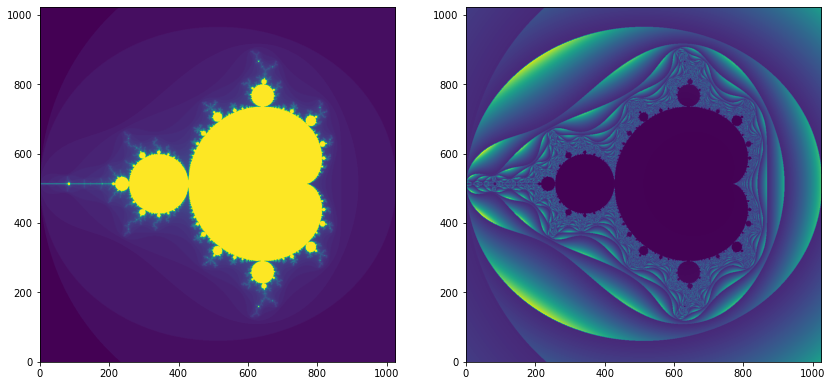

In [19]:
fg = plt.figure(figsize=(14,10))
ax1 = fg.add_subplot(1,2,1)
ax2 = fg.add_subplot(1,2,2)

#plot_extent = (width + 1j * height) * scale
#z1 = center - plot_extent / 2
#z2 = z1 + plot_extent

#ax.imshow(mb_set['Ks']**(1/3), origin='lower', extent=(z1.real, z2.real, z1.imag, z2.imag))
ax1.imshow(mb_set['Ks']**(1/3), origin='lower')
ax2.imshow(mb_set['Zs'], origin='lower')

#ax.set_xlabel("$\Re(c)$")
#ax.set_ylabel("$\Im(c)$")

### jit-compiling Mandelbrot:
- This is pretty prime for `numba.jit()`, we have to make a few changes.
- `numba` cannot compile the `numpy.array()` objects
- I think that is it...

In [22]:
@numba.jit()
#@numba.njit(parallel=True)
def mandelbrotter_jit(re_min=-2.0, im_min=-1.5, re_max=1.0, im_max=1.5, N_x=512, N_y=512, max_iter=256):
#    max_iter = 256
#    width = 256
#    height = 256
#    center = -0.8+0.0j
#    extent = 3.0+3.0j
#    scale = max((extent / width).real, (extent / height).imag)j
    # if given d_re, d_im
    #N_x = int((re_max - re_min)/d_re)
    #N_y = int((im_max - im_min)/d_im)
    d_re = (re_max - re_min)/N_x
    d_im = (im_max - im_min)/N_y
    #
    #print('** DEBUG: ', N_x, N_y)
    #print('** DEBUG: ', d_re, d_im)
    #
    Ks = [[0 for a in range(N_x)] for b in range(N_y)]
    Zs = [[0. for a in range(N_x)] for b in range(N_y)]
    #Ks = numpy.zeros((N_x, N_y), int)
    #Zs = numpy.zeros((N_x, N_y), float)
    #Ks = [[0 for k in range(N_x)] for j in range(N_y)]
    #Zs = [[0. for k in range(N_x)] for j in range(N_y)]
    #
    for j in range(N_y):
        for i in range(N_x):
            #c = center + (i - width // 2 + (j - height // 2)*1j) * scale
            # Note: I make a silly notation mistake with j vs 1*j, that actually works, but 
            #. should probably be avoided.
            c = re_min + d_re*i + 1j*(im_min + d_im*j)
            z = 0. + 0j
            #
            k = 0
            #for k in range(max_iter):
            while k<max_iter and (z*z.conjugate()).real < 4.0:
                #z = z**2 + c
                z = z*z + c
                k+=1
#                if (z * z.conjugate()).real > 4.0:
#                    break
            Ks[j][i] = k
            Zs[j][i] = (z*z.conjugate()).real
        
    #
    #return {'Ks': Ks, 'Zs':Zs}
    return Ks,Zs
      

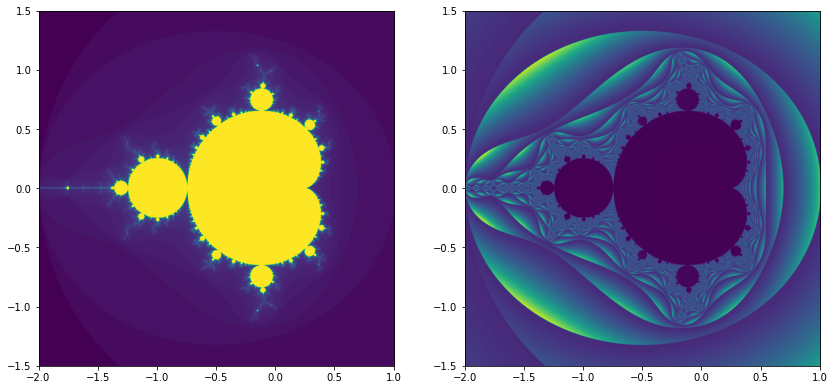

In [23]:
mb_jit = mandelbrotter_jit(N_x=2048, N_y=2048, max_iter=1024, re_min=-2.0, im_min=-1.5, re_max=1.0, im_max=1.5)
#
fg = plt.figure(figsize=(14,10))
ax1 = fg.add_subplot(1,2,1)
ax2 = fg.add_subplot(1,2,2)
#
#plot_extent = (width + 1j * height) * scale
#z1 = center - plot_extent / 2
#z2 = z1 + plot_extent
#
#ax.imshow(mb_set['Ks']**(1/3), origin='lower', extent=(z1.real, z2.real, z1.imag, z2.imag))
ax1.imshow(numpy.array(mb_jit[0])**(1/3), origin='lower', extent=(-2., 1., -1.5, 1.5))
ax2.imshow(numpy.array(mb_jit[1]), origin='lower', extent=(-2., 1., -1.5, 1.5))


### Parralelizing Mandelbrot
- The most direct approach is probably to break up the domain spatially
- Note that loadbalancing will not be perfect; domains that diverge quickly will finish quickly
- The direct rectangular lattice (2D array) is convenient, but complicates breaking up the problem
  - Restrictive, since current implementation requires rectangular chunks, which might not align with the desired number of processes.
  - potentially difficult to put together.
- Consider a `[[x,y,z], ...]` type data format instead...
- In retrospect, I don't think this is a _great_ example where this data structure makes parallelization easier.
- I think the best approach is to still use a `Pool()` over an array of rectangular subdomains, but using this data structure will make it much easier to reassemble.

In [32]:

N_x = 512
N_y = 512
#
#@numba.jit()
#@numba.njit(parallel=True)
def mandelbrotter_xyz(re_min=-2.0, im_min=-1.5, re_max=1.0, im_max=1.5, N_x=N_x, N_y=N_y, max_iter=256):
    #
    d_re = (re_max - re_min)/N_x
    d_im = (im_max - im_min)/N_y
    #
    #print('** DEBUG: ', N_x, N_y)
    #print('** DEBUG: ', d_re, d_im)
    #
    # let's see if we can still manage jit():
    KZs = [[re_min + d_re*n_x, im_min + d_im*n_y, 0, 0.] for n_y, n_x in\
           list( itertools.product(range(N_y), range(N_x)) ) ]
    #Zs = [[re_min + d_re*n_x, im_min + d+im*n_y, 0] for n_y, n_x in itertools.product(range(N_y), range(N_x))]
    #
    for m, (x,y,K,z) in enumerate(KZs):
        #c = center + (i - width // 2 + (j - height // 2)*1j) * scale
        c = x + 1j*y
        z = 0. + 0j
        #
        k = 0
        #
        while k<max_iter and (z*z.conjugate()).real < 4.0:
            #z = z**2 + c
            z = z*z + c
            k+=1
            if (z * z.conjugate()).real > 4.0:
                break
        KZs[m][2] = k
        KZs[m][3] = (z*z.conjugate()).real
        
    #
    #return {'Ks': Ks, 'Zs':Zs}
    return KZs

In [33]:
mb_jit = mandelbrotter_xyz(N_x=N_x, N_y=N_y, max_iter=256, re_min=-2.0, im_min=-1.5, re_max=1.0, im_max=1.5)


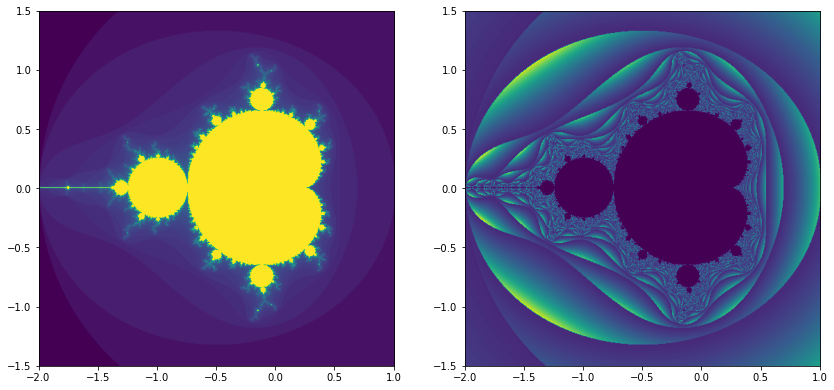

In [37]:
fg = plt.figure(figsize=(14,10))
ax1 = fg.add_subplot(1,2,1)
ax2 = fg.add_subplot(1,2,2)

#plot_extent = (width + 1j * height) * scale
#z1 = center - plot_extent / 2
#z2 = z1 + plot_extent

#ax.imshow(mb_set['Ks']**(1/3), origin='lower', extent=(z1.real, z2.real, z1.imag, z2.imag))
Ks = numpy.array([rw[2] for rw in mb_jit]).reshape(N_y, N_x)
Zs = numpy.array([rw[3] for rw in mb_jit]).reshape(N_y, N_x)
Zs[Zs<2.] = 0.
#
ax1.imshow(Ks**(1/3), origin='lower', extent=(-2., 1., -1.5, 1.5))
ax2.imshow(Zs, origin='lower', extent=(-2., 1., -1.5, 1.5))


### Parallelization: Breaking into subdomains
- Break up domain into $n^2$ subdomains
- Compute subdomains
- View
- Reassemble

#### Stragegy and exercises
- Let's start with the `_jit()` implementation (which uses rectangular arrays); we can also introduce some array assignment notation.
- Note that we have to be careful about integer math on the subdomain boundary pixels
- This complication can be mitigated with a different, maybe indexed possibly less efficient, array structure.
- Consider a Pool() class (or queue() ?). Why?
- What are the (dis-) advantages of using Process() instances?
- For pool, consider and discuss using `map()`, `map_async()`, `apply()`, `apply_async()`, `star_map()`.
- The final task is left to the reader as an exercise.
- Consider other versions of the task that can be parallelized, eg. an assortment of zooms.

** Xs:  [-2. -1.  0.  1.]
** Ys:  [-1.5 -0.5  0.5  1.5]
** [0] -2.0, -1.0, -1.5, -0.5
** [1] -1.0, 0.0, -1.5, -0.5
** [2] 0.0, 1.0, -1.5, -0.5
** [3] -2.0, -1.0, -0.5, 0.5
** [4] -1.0, 0.0, -0.5, 0.5
** [5] 0.0, 1.0, -0.5, 0.5
** [6] -2.0, -1.0, 0.5, 1.5
** [7] -1.0, 0.0, 0.5, 1.5
** [8] 0.0, 1.0, 0.5, 1.5


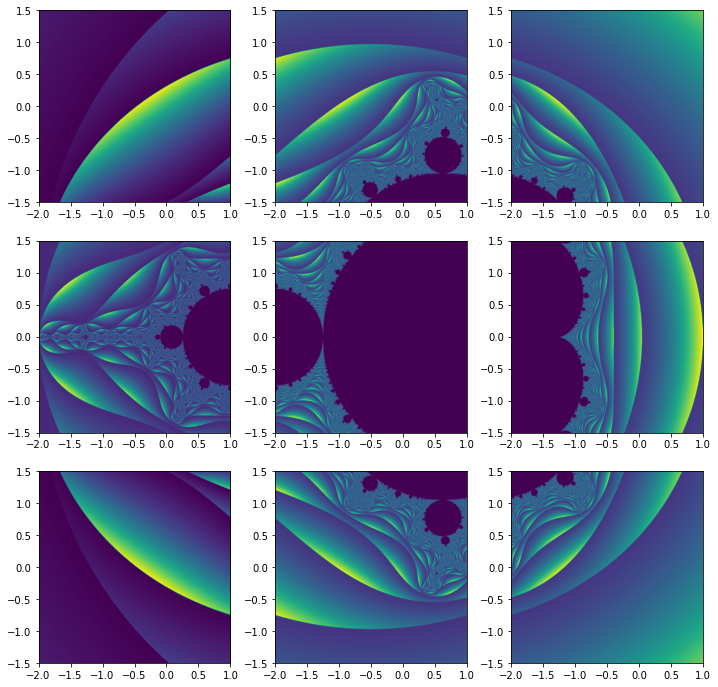

In [52]:
# We see the debate between splitting on the continuum vs discrete pixels.

Re_0 = -2.0
Re_1 = 1.0
Im_0 = -1.5
Im_1 = 1.5
#
N_x = 1024
N_y = 1024
#
n_side = 3
nits = 512
#
# compute and show the subdomains
N_xs = int(N_x/n_side)
N_ys = int(N_y/n_side)
#
Xs = numpy.linspace(Re_0, Re_1, n_side+1)
Ys = numpy.linspace(Im_0, Im_1, n_side+1)
print('** Xs: ', Xs)
print('** Ys: ', Ys)
#
fg = plt.figure(figsize=(12,12))
axes = [fg.add_subplot(n_side, n_side, k+1) for k in range(n_side*n_side)]
fig_map = {0:0}
#
for k, ( (y1,y2), (x1,x2) )in enumerate(itertools.product(zip(Ys[0:-1], Ys[1:]), zip(Xs[0:-1], Xs[1:]))):
    print(f'** [{k}] {x1}, {x2}, {y1}, {y2}')
    mb_jit = mandelbrotter_jit(N_x=N_x, N_y=N_y, max_iter=256, re_min=x1, im_min=y1, re_max=x2, im_max=y2)
    Zs = numpy.array(mb_jit[1])
    Zs[Zs<2.] = 0.
#
    axes[k].imshow(Zs, origin='upper', extent=(-2., 1., -1.5, 1.5))
    

### Exercise: Perform the sub-domain Mandelbroc computaton, and reassembly (Not shown...) in parallel. Consider using `Pool()` with different `map()` and `apply()` methods.